<h4>Imports</h4>

In [392]:
#NOTE: autoreload is not recursive, only direct imports are reloaded
%load_ext autoreload
%autoreload 2
from data_translator import TestTranslator, EncodeForGA, GAToScheduleTranslator
from hybrid_solution_data_loader import get_data
from models import Order, SimulationEnvironment, Schedule
from solver import GASolver, PSOSolver, GreedyAgentSolver
from visualize import visualize_schedule_demo
import objective_function

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Config

In [393]:
available_solvers = ["GASolver", "PSOSolver", "GreedyAgentSolver"]
use_solver = available_solvers[0]
save_file = True
file_name = 'just_testing' # NOTE: only change this name for saving files

full_name = f'{file_name}_{use_solver}'

<h4>Read from Source</h4>

In [394]:
n_workstations, recipes, operation_times = get_data(0)
recipies, workstations, resources, tasks, _ = TestTranslator().translate(n_workstations, recipes, operation_times)

env = SimulationEnvironment(workstations, tasks, resources, recipies)

<h4>Create Orders</h4>

In [395]:
earliest_slot = 0
last_slot = 100
recipe_orders = [0, 1, 2, 3, 0, 3, 2, 1, 0, 3] # for dataset 0
orders = []
o_id = 0
for order in recipe_orders:
    orders.append(Order(o_id, 0, last_slot, last_slot, [order], 100, 50, False, 0, False, 500)) # for now: use resources to select recipe
    o_id = o_id + 1


<h4>Translate for Solver</h4>

In [396]:
if use_solver == "GASolver" or use_solver == "PSOSolver" or use_solver == "GreedyAgentSolver": # NOTE: all solvers use the same encoding right now
    # translate datamodel to encoding
    encoder = EncodeForGA()
    # TODO: alternatives can be completely removed (TEST first)
    values, durations, all_jobs, alternatives = encoder.translate(env, orders) # encoding, duration lookup table, list of all jobs used (probably not needed), possible alternatives for each job


<h4>Run Solver</h4>

GA

In [397]:
if use_solver == "GASolver":
    #NOTE: Best makespan so far: 22
    crossover = 'two_points' #NOTE: available in PyGAD: 'two_points', 'single_point', 'uniform', 'scattered'
    selection = 'rws' #NOTE: available in PyGAD: 'sss' (steady state selection', 'rws' (roulette wheel), 'sus' (stochastic universal selection), 'rank' (rank selection), 'random' (random selection), 'tournament' (tournament selection)
    mutation = 'workstation_only' #NOTE: available options: 'workstation_only', 'full_random', 'random_only_feasible' #NOTE 2: so far only workstation_only can find feasible results
    population_size = 50
    offspring_amount = 100
    max_generations = 2000

    solver = GASolver(values, durations, all_jobs, alternatives, env, orders)
    solver.initialize(earliest_slot, last_slot, population_size, offspring_amount, max_generations, crossover=crossover, selection=selection, mutation=mutation)
    solver.run()

Done


In [398]:
if use_solver == "GASolver":
    # just for comparison, so the optimizers don't have to run over and over again
    ga_result = solver.get_best()
    ga_fitness = solver.get_best_fitness()

PSO 

In [399]:
if use_solver == "PSOSolver":
    #NOTE: no best makespan yet
    solver = PSOSolver(values, durations, all_jobs, env, orders)

    #solver.initialize(earliest_slot, last_slot, c1=0.5, c2=0.3, w=0.5, max_iter=5000)
    solver.initialize(earliest_slot, last_slot, c1=2, c2=2, w=0.1, max_iter=25000) # 'widely used values for integer optimization' https://www.researchgate.net/publication/3949434_Particle_swarm_optimization_for_integer_programming
    solver.run()

In [400]:
if use_solver == "PSOSolver":
    # just for comparison, so the optimizers don't have to run over and over again
    pso_result = solver.get_best()
    pso_fitness = solver.get_best_fitness()

Greedy Agent

In [401]:
if use_solver == "GreedyAgentSolver":
    #NOTE: Best makespan so far: 26
    solver = GreedyAgentSolver(values, durations, all_jobs, env, orders)
    solver.run()

In [402]:
if use_solver == "GreedyAgentSolver":
    # just for comparison, so the optimizers don't have to run over and over again
    greedy_result = solver.get_best()
    greedy_fitness = solver.get_best_fitness()

<h4>Result Output</h4>

In [403]:
result = solver.get_best()
fitness = solver.get_best_fitness()
#result = greedy_result
#fitness = greedy_fitness
#result = pso_result
#fitness = pso_fitness
#result = ga_result
#fitness = ga_fitness

print("Parameters of the best solution : {solution}".format(solution=result))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=abs(fitness)))
fitness_history = solver.assignments_best
average_fitness_history = solver.average_assignments


Parameters of the best solution : [ 3  0  4  1  4  6  1  0  0  5  0 10  3  1  1  8  0 14  0 16  1  9  1 14
  3  8  3  9  0 20  2  0  3 16  2  2  1 15  3 17  3 19  2  8  2 12  2 21
  4 11  4 13  4 18  1 16  1 21]
Fitness value of the best solution = 25


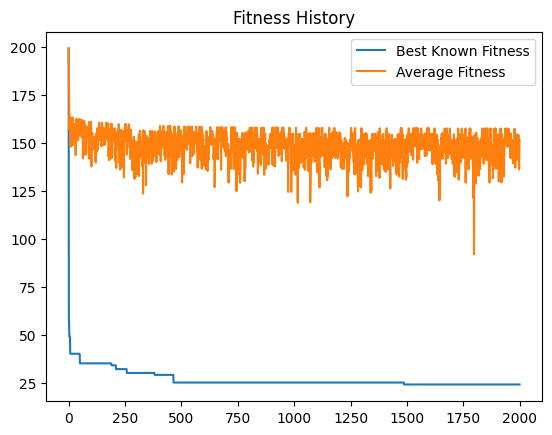

In [404]:
import matplotlib.pyplot as plt
if not len(fitness_history) == 0 and not len(average_fitness_history) == 0:
    x = list(range(0, len(fitness_history)))
    plt.plot(x, fitness_history)
    plt.plot(x, average_fitness_history)
    plt.title('Fitness History')
    plt.legend(['Best Known Fitness', 'Average Fitness'])
    plt.xlabel = 'Generation'
    plt.ylabel = 'Fitness'
    plt.show()

<h4>(Optional) Postprocessing</h4>

<h4>Translate to Schedule</h4>

In [405]:
schedule = GAToScheduleTranslator().translate(result, all_jobs, env, orders)
schedule.created_in = env
schedule.created_for = orders

<h4>Visualize Schedule</h4>

In [406]:
visualize_schedule_demo(schedule, env, orders)

<h4>Evaluate Schedule</h4>

In [407]:
#NOTE: the objective functions in this case assume the solution is feasible, no additional checks
#NOTE: currently the only objective function used during optimization is makespan
makespan, tardiness, deviation, idle_time, profit = objective_function.calculate_comparison_values(schedule, orders, env)
print(f'Fitness Values:\nMakespan: {makespan}\nTardiness: {tardiness}\nDeviation: {deviation}\nIdle Time: {idle_time}\nProfit: {profit}')

Fitness Values:
Makespan: 25
Tardiness: 0
Deviation: 809
Idle Time: 9
Profit: 5000


(Optional) Save Result as JSON for later comparison

In [408]:
"""import json
import orjson # library is supposed to be able to handle numpy values
import numpy as np

# doesn't work for some reason (can't save GASolver results currently because of numpy values)
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.int64):
            return int(obj)
        if isinstance(obj, list) and len(obj) > 0 and (isinstance(obj[0], np.int32) or isinstance(obj[0], np.int64)):
            newlist = list()
            for value in obj:
                newlist.append(int(value))
            return newlist
        return json.JSONEncoder.default(self, obj)

def read_dict(obj):
    for key, value in obj.__dict__.items():
        if not isinstance(key, str):
            print(f'Panic: {key} is not a string')
        if hasattr(value, '__dict__'):
            read_dict(value)
        else:
            if isinstance(value, np.int64) or isinstance(value, np.int32) or isinstance(value, list):
                if isinstance(value, list) and len(value) > 0 and (isinstance(value[0], np.int32) or isinstance(value[0], np.int64)):
                    print(key)
                    print(type(value[0]))
                elif isinstance(value, np.int64) or isinstance(value, np.int32):
                    print(key)
                    print(type(value))


solver.environment = None # just make the file smaller and smaller
solver.orders = None
schedule.created_by = solver

if use_solver == "GASolver":
    solver.ga_instance = None
    solver.instance = None
    assignment_best = solver.assignments_best
    for i in range(len(assignment_best)):
        assignment_best[i] = int(assignment_best[i])
    solver.assignments_best = assignment_best
    best = solver.best_solution
    solver.solution_index = int(solver.solution_index)
    #best_list_int = []
    #for i in range(len(best[0])):
    #    best_list_int.append(int(best[0][i]))
    #solver.best_solution = best_list_int
read_dict(solver) # trying to find weird int32 values for GA
schedule.evaluation_results = []
schedule.evaluation_results.append(('makespan', makespan))
schedule.evaluation_results.append(('tardiness', tardiness))
schedule.evaluation_results.append(('deviation', deviation))
schedule.evaluation_results.append(('idle_time', idle_time))
schedule.evaluation_results.append(('profit', profit))


if(save_file):
    jsonstring = json.dumps(schedule.__dict__, default=lambda o : o.__dict__, indent=4, cls=NpEncoder)
    #jsonstring = orjson.dumps(schedule.__dict__, option=orjson.OPT_SERIALIZE_NUMPY)
    with open(f'results/{file_name}.json', "w") as outfile:
        outfile.write(jsonstring)"""


'import json\nimport orjson # library is supposed to be able to handle numpy values\nimport numpy as np\n\n# doesn\'t work for some reason (can\'t save GASolver results currently because of numpy values)\nclass NpEncoder(json.JSONEncoder):\n    def default(self, obj):\n        if isinstance(obj, np.integer):\n            return int(obj)\n        if isinstance(obj, np.floating):\n            return float(obj)\n        if isinstance(obj, np.ndarray):\n            return obj.tolist()\n        if isinstance(obj, np.int64):\n            return int(obj)\n        if isinstance(obj, list) and len(obj) > 0 and (isinstance(obj[0], np.int32) or isinstance(obj[0], np.int64)):\n            newlist = list()\n            for value in obj:\n                newlist.append(int(value))\n            return newlist\n        return json.JSONEncoder.default(self, obj)\n\ndef read_dict(obj):\n    for key, value in obj.__dict__.items():\n        if not isinstance(key, str):\n            print(f\'Panic: {key} i

In [409]:
import pickle

solver.environment = None # make file smaller, since the schedule already knows the environment and the orders
solver.orders = None
schedule.created_by = solver
schedule.evaluation_results = []
schedule.evaluation_results.append(('makespan', makespan))
schedule.evaluation_results.append(('tardiness', tardiness))
schedule.evaluation_results.append(('deviation', deviation))
schedule.evaluation_results.append(('idle_time', idle_time))
schedule.evaluation_results.append(('profit', profit))

if(save_file):
    with open(f'results/{full_name}.pickle', 'wb') as outfile:
        pickled_data = pickle.dump(schedule, outfile)
